In [ ]:
!pip install creversi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 711.0/711.0 kB 4.5 MB/s eta 0:00:00


In [ ]:
import gym
import creversi.gym_reversi
from creversi import *

import sys
import os
import datetime
import math
import random
import numpy as np
from collections import namedtuple
from itertools import count
import logging

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import display, SVG

/usr/local/lib/python3.10/dist-packages/creversi/__init__.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .creversi import *


In [ ]:
resume = ''
logging.basicConfig(format='%(asctime)s %(levelname)s %(message)s', datefmt='%Y-%m-%d %H:%M:%S', stream=sys.stdout, level=logging.DEBUG, force=True)

env = gym.make('Reversi-v0').unwrapped

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

######################################################################
# Replay Memory

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'next_actions', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


######################################################################
# DQN

k = 192
fcl_units = 256
class DQN(nn.Module):
  def __init__(self):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(2, k, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(k)
    self.conv2 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(k)
    self.conv3 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(k)
    self.conv4 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn4 = nn.BatchNorm2d(k)
    self.conv5 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn5 = nn.BatchNorm2d(k)
    self.conv6 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn6 = nn.BatchNorm2d(k)
    self.conv7 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn7 = nn.BatchNorm2d(k)
    self.conv8 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn8 = nn.BatchNorm2d(k)
    self.conv9 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn9 = nn.BatchNorm2d(k)
    self.conv10 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn10 = nn.BatchNorm2d(k)
    self.fcl1 = nn.Linear(k * 64, fcl_units)
    self.fcl2 = nn.Linear(fcl_units, 65)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = F.relu(self.bn5(self.conv5(x)))
    x = F.relu(self.bn6(self.conv6(x)))
    x = F.relu(self.bn7(self.conv7(x)))
    x = F.relu(self.bn8(self.conv8(x)))
    x = F.relu(self.bn9(self.conv9(x)))
    x = F.relu(self.bn10(self.conv10(x)))
    x = F.relu(self.fcl1(x.view(-1, k * 64)))
    x = self.fcl2(x)
    return x.tanh()

def get_state(board):
    features = np.empty((1, 2, 8, 8), dtype=np.float32)
    board.piece_planes(features[0])
    state = torch.from_numpy(features[:1]).to(device)
    return state

######################################################################
# Training

BATCH_SIZE = 256
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000
OPTIMIZE_PER_EPISODES = 16
TARGET_UPDATE = 4

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-5)

if resume:
    print('resume {}'.format(resume))
    checkpoint = torch.load(resume)
    target_net.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

memory = ReplayMemory(131072)

def epsilon_greedy(state, legal_moves):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * episodes_done / EPS_DECAY)

    if sample > eps_threshold:
        with torch.no_grad():
            q = policy_net(state)
            _, select = q[0, legal_moves].max(0)
    else:
        select = random.randrange(len(legal_moves))
    return select

temperature = 0.5
def softmax(state, legal_moves):
    with torch.no_grad():
        q = policy_net(state)
        log_prob = q[0, legal_moves] / temperature
        select = torch.distributions.categorical.Categorical(logits=log_prob).sample()
    return select

def select_action(state, board):

    legal_moves = list(board.legal_moves)

    select = epsilon_greedy(state, legal_moves)
    #select = softmax(state, board.legal_moves)

    return legal_moves[select], torch.tensor([[legal_moves[select]]], device=device, dtype=torch.long)


######################################################################
# Training loop

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # 合法手のみ
    non_final_next_actions_list = []
    for next_actions in batch.next_actions:
        if next_actions is not None:
            non_final_next_actions_list.append(next_actions + [next_actions[0]] * (30 - len(next_actions)))
    non_final_next_actions = torch.tensor(non_final_next_actions_list, device=device, dtype=torch.long)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # 合法手のみの最大値
    target_q = target_net(non_final_next_states)
    # 相手番の価値のため反転する
    next_state_values[non_final_mask] = -target_q.gather(1, non_final_next_actions).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = next_state_values * GAMMA + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    logging.info(f"{episodes_done}: loss = {loss.item()}")

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (8, 8)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


2023-12-23 03:58:52 DEBUG Initializing MLIR with module: _site_initialize_0
2023-12-23 03:58:52 DEBUG Registering dialects from initializer <module 'jaxlib.mlir._mlir_libs._site_initialize_0' from '/usr/local/lib/python3.10/dist-packages/jaxlib/mlir/_mlir_libs/_site_initialize_0.so'>
2023-12-23 03:58:52 DEBUG etils.epath found. Using etils.epath for file I/O.


In [ ]:
######################################################################
# main training loop

episodes_done = 0
for i_episode in range(12000):
    # Initialize the environment and state
    env.reset()
    state = get_state(env.board)

    for t in count():
        # Select and perform an action
        move, action = select_action(state, env.board)
        next_board, reward, done, is_draw = env.step(move)

        # todo: players

        # display(SVG(env.board.to_svg(move)))
        # print(move)


        reward = torch.tensor([reward], device=device)
        # print(reward)

        # Observe new state
        if not done:
            next_state = get_state(next_board)
            next_actions = list(next_board.legal_moves)
        else:
            next_state = None
            next_actions = None

        # Store the transition in memory
        memory.push(state, action, next_state, next_actions, reward)

        if done:
            break

        # Move to the next state
        state = next_state

    episodes_done += 1

    if i_episode % OPTIMIZE_PER_EPISODES == OPTIMIZE_PER_EPISODES - 1:
        # Perform several episodes of the optimization (on the target network)
        optimize_model()

        # Update the target network, copying all weights and biases in DQN
        if i_episode // OPTIMIZE_PER_EPISODES % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

model = 'epsilon_greedy_model.pt'
print('save {}'.format(model))
torch.save({'state_dict': target_net.state_dict(), 'optimizer': optimizer.state_dict()}, model)

print('Complete')
env.close()

In [ ]:
class RandomPlayer:
    def go(self, board):
        legal_moves = board.legal_moves
        if len(legal_moves) == 0:
            return PASS
        else:
            return random.choice(list(legal_moves))

class GreedyPlayer:
    def __init__(self, model_path, device, network='dqn'):
        # if network == 'dueling':
        #     from creversi_gym.network.cnn10_dueling import DQN
        # else:
        #     #from creversi_gym.network.cnn5 import DQN
        #     from creversi_gym.network.cnn10 import DQN
        self.device = device
        self.model = DQN().to(device)
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.model.eval()
        self.features = np.empty((1, 2, 8, 8), np.float32)

    def go(self, board):
        with torch.no_grad():
            board.piece_planes(self.features[0])
            state = torch.from_numpy(self.features).to(self.device)
            q = self.model(state)
            # 合法手に絞る
            legal_moves = list(board.legal_moves)
            next_actions = torch.tensor([legal_moves], device=self.device, dtype=torch.long)
            legal_q = q.gather(1, next_actions)
            return legal_moves[legal_q.argmax(dim=1).item()]

In [ ]:
def vs(board, player1, player2):
  player1name = player1.__class__.__name__
  player2name = player2.__class__.__name__
  print(player1name + " vs " + player2name)
  print(player1name + " Go First")
  while board.is_game_over() == False:
    board.move(player1.go(board))
    board.move(player2.go(board))
  n_white = 64 - board.piece_num()
  n_black = board.piece_num()
  if n_white > n_black:
    winner = 2
    print("White Win!")
  elif n_black > n_white:
    winner = 1
    print("Black Win!")
  else:
    winner = 0
    print("Draw!")
  print("White:",n_white)
  print("Black:",n_black)
  return board

def vs_notext(board, player1, player2):
  while board.is_game_over() == False:
    board.move(player1.go(board))
    board.move(player2.go(board))
  n_white = 64 - board.piece_num()
  n_black = board.piece_num()
  if n_white > n_black:
    winner = 2
  elif n_black > n_white:
    winner = 1
  else:
    winner = 0
  return winner

In [ ]:
rp = RandomPlayer()
gp = GreedyPlayer("/content/epsilon_greedy_model.pt", device)

RandomPlayer vs GreedyPlayer
RandomPlayer Go First
White Win!
White: 33
Black: 31


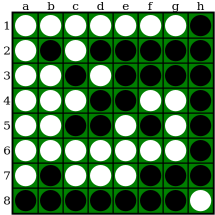

In [ ]:
newboard = creversi.Board()
vs(newboard, rp, gp)

In [ ]:
rpwin = 0
gpwin = 0
draw = 0
for i in range(500):
  board = creversi.Board()
  result = vs_notext(board, rp, gp)
  if result == 1:
    rpwin += 1
  elif result == 2:
    gpwin += 1
  else:
    draw += 1

  board = creversi.Board()
  result = vs_notext(board, gp, rp)
  if result == 1:
    gpwin += 1
  elif result == 2:
    rpwin += 1
  else:
    draw += 1

In [ ]:
print("RandomPlayer vs GreedyPlayer")
print("RandomPlayer Win:", rpwin)
print("GreedyPlayer Win:", gpwin)
print("Draw:", draw)
print("RandomPlayer Win Rate:", rpwin/(rpwin+gpwin+draw))
print("GreedyPlayer Win Rate:", gpwin/(rpwin+gpwin+draw))

RandomPlayer vs GreedyPlayer
RandomPlayer Win: 407
GreedyPlayer Win: 556
Draw: 37
RandomPlayer Win Rate: 0.407
GreedyPlayer Win Rate: 0.556


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rp1 = RandomPlayer()
rp2 = RandomPlayer()

rp1win = 0
rp2win = 0
draw = 0
for i in range(500):
  board = creversi.Board()
  result = vs_notext(board, rp1, rp2)
  if result == 1:
    rp1win += 1
  elif result == 2:
    rp2win += 1
  else:
    draw += 1

  board = creversi.Board()
  result = vs_notext(board, rp2, rp1)
  if result == 1:
    rp2win += 1
  elif result == 2:
    rp1win += 1
  else:
    draw += 1

In [ ]:
print("RandomPlayer vs RandomPlayer")
print("RandomPlayer1 Win:", rp1win)
print("RandomPlayer2 Win:", rp2win)
print("Draw:", draw)
print("RandomPlayer1 Win Rate:", rp1win/(rp1win+rp2win+draw))
print("RandomPlayer2 Win Rate:", rp2win/(rp1win+rp2win+draw))

RandomPlayer vs RandomPlayer
RandomPlayer1 Win: 492
RandomPlayer2 Win: 474
Draw: 34
RandomPlayer1 Win Rate: 0.492
RandomPlayer2 Win Rate: 0.474


In [ ]:
gp1 = GreedyPlayer("/content/epsilon_greedy_model.pt", device)
gp2 = GreedyPlayer("/content/epsilon_greedy_model.pt", device)

gp1win = 0
gp2win = 0
draw = 0
for i in range(500):
  board = creversi.Board()
  result = vs_notext(board, gp1, gp2)
  if result == 1:
    gp1win += 1
  elif result == 2:
    gp2win += 1
  else:
    draw += 1

  board = creversi.Board()
  result = vs_notext(board, gp2, gp1)
  if result == 1:
    gp2win += 1
  elif result == 2:
    gp1win += 1
  else:
    draw += 1

In [ ]:
print("GreedyPlayer vs GreedyPlayer")
print("GreedyPlayer1 Win:", gp1win)
print("GreedyPlayer2 Win:", gp2win)
print("Draw:", draw)
print("GreedyPlayer1 Win Rate:", gp1win/(gp1win+gp2win+draw))
print("GreedyPlayer2 Win Rate:", gp2win/(gp1win+gp2win+draw))

GreedyPlayer vs GreedyPlayer
GreedyPlayer1 Win: 500
GreedyPlayer2 Win: 500
Draw: 0
GreedyPlayer1 Win Rate: 0.5
GreedyPlayer2 Win Rate: 0.5


In [ ]:
import creversi
import random

class QLearning:
    def __init__(self):
        self.q_table = {}

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def update_q_value(self, state, action, value):
        self.q_table[(state, action)] = value

class QAgent:
    def __init__(self, epsilon=0.1, alpha=0.1, gamma=0.9):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.q_learning = QLearning()

    def choose_action(self, state, legal_moves):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(legal_moves)
        else:
            q_values = [self.q_learning.get_q_value(state, action) for action in legal_moves]
            max_q_value = max(q_values)
            best_actions = [action for action, value in zip(legal_moves, q_values) if value == max_q_value]
            return random.choice(best_actions)

    def train(self, state, action, reward, next_state, legal_moves):
        current_q_value = self.q_learning.get_q_value(state, action)
        max_next_q_value = max([self.q_learning.get_q_value(next_state, next_action) for next_action in legal_moves])
        new_q_value = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_next_q_value)
        self.q_learning.update_q_value(state, action, new_q_value)

    def reset_q_table(self):
        self.q_learning = QLearning()

class RandomAgent:
    def choose_action(self, state, legal_moves):
        return random.choice(legal_moves)

In [ ]:
def print_board(board):
    print(str(board))

def play_game(q_agent, opponent_agent, board, first = True):
    if first:
      current_agent = q_agent
    else:
      current_agent = opponent_agent

    while not board.is_game_over():
        state = str(board)
        legal_moves = [creversi.move_to_str(move) for move in board.legal_moves]

        # print_board(board)

        if isinstance(current_agent, QAgent):
            action = current_agent.choose_action(state, legal_moves)
            board.move_from_str(action)
        else:
            action = opponent_agent.go(board)
            board.move(action)

        # board.move_from_str(action)
        current_agent = opponent_agent if current_agent == q_agent else q_agent

    # print("end with q_agent" if current_agent == q_agent else "end with opponent_agent")
    if first:
      firstname = "q_agent"
      secondname = "opponent_agent"
    else:
      firstname = "opponent_agent"
      secondname = "q_agent"
    if current_agent == opponent_agent:
      n_black = 64 - board.piece_num()
      n_white = board.piece_num()
    else:
      n_white = 64 - board.piece_num()
      n_black = board.piece_num()
    if n_white > n_black:
      if first:
        winner = 2
      else:
        winner = 1
      print(secondname + " white win", n_white)
    elif n_black > n_white:
      if first:
        winner = 1
      else:
        winner = 2
      print(firstname + " black win", n_black)
    else:
      winner = 0
      print("draw")

    return winner

In [ ]:
q_agent = QAgent()
opponent_agent = GreedyPlayer("/content/epsilon_greedy_model.pt", device)
board = creversi.Board()

opponent_agentcount = 0
q_agentcount = 0

In [ ]:
round = 500
for i in range(round):
  board = creversi.Board()
  result = play_game(q_agent, opponent_agent, board, True)
  if result == 1:
    q_agentcount += 1
  elif result == 2:
    opponent_agentcount += 1
  board = creversi.Board()
  result = play_game(q_agent, opponent_agent, board, False)
  if result == 1:
    q_agentcount += 1
  elif result == 2:
    opponent_agentcount += 1

opponent_agent white win 49
q_agent white win 47
opponent_agent white win 40
opponent_agent black win 38
q_agent black win 55
q_agent white win 37
opponent_agent white win 39
q_agent white win 46
q_agent black win 35
q_agent white win 40
opponent_agent white win 49
q_agent white win 41
opponent_agent white win 39
draw
opponent_agent white win 51
q_agent white win 51
opponent_agent white win 43
opponent_agent black win 37
opponent_agent white win 35
opponent_agent black win 36
q_agent black win 51
opponent_agent black win 36
opponent_agent white win 47
q_agent white win 54
q_agent black win 33
q_agent white win 39
opponent_agent white win 47
opponent_agent black win 40
opponent_agent white win 46
q_agent white win 36
draw
q_agent white win 46
opponent_agent white win 39
opponent_agent black win 38
opponent_agent white win 34
q_agent white win 35
opponent_agent white win 33
opponent_agent black win 33
opponent_agent white win 39
opponent_agent black win 55
q_agent black win 36
q_agent wh

In [ ]:
print("q_agent win", q_agentcount)
print("opponent_agent win", opponent_agentcount)
print("draw", round * 2 - q_agentcount - opponent_agentcount)

q_agent win 451
opponent_agent win 511
draw 38


In [ ]:
print("q_agent winrate", q_agentcount / (round * 2))
print("opponent_agent winrate", opponent_agentcount / (round * 2))

q_agent winrate 0.451
opponent_agent winrate 0.511
